# A Guided Tour of Ray Core: Remote Tasks

© 2019-2022, Anyscale. All Rights Reserved

📖 [Back to Table of Contents](./ex_00_tutorial_overview.ipynb)<br>
➡ [Next notebook](./ex_02_remote_objs.ipynb) <br>

### Introduction

Ray enables arbitrary functions to be executed asynchronously on separate Python workers. These asynchronous Ray functions are called “tasks.” You can specify task's resource requirements in terms of CPUs, GPUs, and custom resources. These resource requests are used by the cluster scheduler to distribute tasks across the cluster for parallelized execution.  

|<img src="images/py_2_ray.png" height="45%" width="60%">|
|:--|
|Transforming Python code into Ray Tasks, Actors, and Immutable Ray objects.|

### Learning objectives
In this this tutorial, we learn about:
 * Remote Task Parallel Pattern
 * Stateless remote functions as distributed tasks
 * Serial vs Parallel execution 
 * Understand the concept of a Ray task 
 * Easy API to convert an existing Python function into a Ray remote task
 * Walk through examples comparing serial vs. distributed Python functions and Ray tasks respectively

In [44]:
import os
import time
import logging
import math
import random
from pathlib import Path
from typing import Tuple, List
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import tqdm
import ray

## 1. Tasks Parallel Pattern

Ray converts decorated functions with `@ray.remote` into stateless tasks, scheduled anywhere on a Ray node's worker in the cluster. 

Where they will be executed on the cluster (and on what node by which worker process), you don't have to worry about its details. All that is taken care for you. Nor do 
you have to reason about it — all that burden is Ray's job. You simply take your existing Python functions and covert them into 
distributed stateless *Ray Tasks*: **as simple as that!**

### Serial vs Parallelism Execution

 
|<img src="images/sequential_timeline.png" width="70%" loading="lazy">|
|:--|
|Timeline of sequential tasks, one after the other.|

|<img src="images/distributed_timeline.png" width="70%" loading="lazy">|
|:--|
|Sample timeline with ten tasks running across 4 worker nodes in parallel with minor overhead from scheduler.|


Let's look at some tasks running serially and then in parallel. For illustration, we'll use a the following tasks:
 * generating fibonacci numbers serially and distributed
 * computing value of pi using the monte carlo method
 * doing batch inference using Ray tasks

There are a few key differences between the original function and the decorated one:

**Invocation**: The regular version is called with `func_name()`, whereas the remote version is called with `func_name.remote()`. Keep this pattern in mind for all Ray remote execution methods.

**Mode of execution and return values**: `func_name()` executes synchronously and returns the result of the function, whereas a Ray task `func_name.remote()`immediately returns an `ObjectID` (a future) and then executes the task in the background on a remote worker process. The result of the future is obtained by calling `ray.get(ObjectRef)` on the `ObjectRef`. This is a blocking function.

Let's launch a Ray cluster on our local machine.

In [37]:
if ray.is_initialized:
    ray.shutdown()
ray.init(logging_level=logging.ERROR)

Python version:,3.8.13
Ray version:,2.2.0
Dashboard:,http://127.0.0.1:8265


### Example 1: Generating Fibonnaci series

Let's define two functions: one runs serially, the other runs on a Ray cluster (local or remote). This example is borrowed and refactored from our 
blog: [Writing your First Distributed Python Application with Ray](https://www.anyscale.com/blog/writing-your-first-distributed-python-application-with-ray). 
(This is an excellent tutorial to get started with the concept of why and when to use Ray tasks and Ray Actors. Highly recommended read!)

In [3]:
SEQUENCE_SIZE = 100000

In [4]:
# Function for local execution 
def generate_fibonacci(sequence_size):
    fibonacci = []
    for i in range(0, sequence_size):
        if i < 2:
            fibonacci.append(i)
            continue
        fibonacci.append(fibonacci[i-1]+fibonacci[i-2])
    return len(fibonacci)

In [5]:
# Function for remote Ray task with just a wrapper
@ray.remote
def generate_fibonacci_distributed(sequence_size):
    return generate_fibonacci(sequence_size)

In [6]:
# Get the number of cores 
os.cpu_count()

10

In [7]:
# Normal Python in a single process 
def run_local(sequence_size):
    results = [generate_fibonacci(sequence_size) for _ in range(os.cpu_count())]
    return results

In [8]:
%%time
run_local(SEQUENCE_SIZE)

CPU times: user 1.49 s, sys: 586 ms, total: 2.08 s
Wall time: 2.07 s


[100000,
 100000,
 100000,
 100000,
 100000,
 100000,
 100000,
 100000,
 100000,
 100000]

In [9]:
# Distributed on a Ray cluster
def run_remote(sequence_size):
    results = ray.get([generate_fibonacci_distributed.remote(sequence_size) for _ in range(os.cpu_count())])
    return results

In [10]:
%%time
run_remote(SEQUENCE_SIZE)

CPU times: user 18 ms, sys: 7.86 ms, total: 25.8 ms
Wall time: 393 ms


[100000,
 100000,
 100000,
 100000,
 100000,
 100000,
 100000,
 100000,
 100000,
 100000]

### Exercise

1. Increase the fibonacci with 200K, 300K and observe the execution times

### Example 2:  Monte Carlo simulation of estimating pi

Let's estimate the value of π using a [Monte Carlo](https://en.wikipedia.org/wiki/Monte_Carlo_method) method. We randomly sample points within a 2x2 square. We can use the proportion of the points that are contained within the unit circle centered at the origin to estimate the ratio of the area of the circle to the area of the square. 

Given we know that the true ratio to be π/4, we can multiply our estimated ratio by 4 to approximate the value of π. The more points that we sample to calculate this approximation, the closer we get to true value of π.

|<img src="https://docs.ray.io/en/latest/_images/monte_carlo_pi.png" width="60%" height="30%">|
|:--|
|Estimating the value of π by sampling random points that fall into the circle.|


In [11]:
# Change this to match your cluster scale.
NUM_SAMPLING_TASKS = os.cpu_count()
NUM_SAMPLES_PER_TASK = 10_000_000
TOTAL_NUM_SAMPLES = NUM_SAMPLING_TASKS * NUM_SAMPLES_PER_TASK

Define a regular function that computes the number of samples
in the circle. This is done by randomly sampling `num_samples` for
x, y between a uniform value of (-1, 1). Using the [math.hypot](https://docs.python.org/3/library/math.html#math.hypot) function, we
compute if it falls within the circle.

In [12]:
def sampling_task(num_samples: int, task_id: int, verbose=True) -> int:
    num_inside = 0
    for i in range(num_samples):
        x, y = random.uniform(-1, 1), random.uniform(-1, 1)
        # check if the point is inside the circle
        if math.hypot(x, y) <= 1:
            num_inside += 1
    if verbose:
        print(f"Task id: {task_id} | Samples in the circle: {num_inside}")
    return num_inside

Define a function to run this serially, by launcing `NUM_SAMPLING_TASKS` serial tasks in a comprehension list.

In [13]:
def run_serial(sample_size) -> List[int]:
    results = [sampling_task(sample_size, i+1) for i in range(NUM_SAMPLING_TASKS)]
    return results

Define a funciton to run this as a remote Ray task, which invokes our sampling function, but since it's decorated
with `@ray.remote`, the task will run on a worker process, tied to a core, on the Ray cluster.

In [14]:
@ray.remote
def sample_task_distribute(sample_size, i) -> object:
    return sampling_task(sample_size, i)


In [15]:
def run_disributed(sample_size) -> List[int]:
    # Launch Ray remote tasks in a comprehension list, each returns immediately with a future ObjectRef 
    # Use ray.get to fetch the computed value; this will block until the ObjectRef is resolved or its value is materialized.
    results = ray.get([
            sample_task_distribute.remote(sample_size, i+1) for i in range(NUM_SAMPLING_TASKS)
        ])
    return results

Define a function to calculate the value of π by getting all number of samples inside the circle from the sampling tasks and calculate π.

In [16]:
def calculate_pi(results: List[int]) -> float:
    total_num_inside = sum(results)
    pi = (total_num_inside * 4) / TOTAL_NUM_SAMPLES
    return pi

### Run calculating π serially

In [17]:
print(f"Running {NUM_SAMPLING_TASKS} tasks serially....")

Running 10 tasks serially....


In [18]:
%%time
results = run_serial(NUM_SAMPLES_PER_TASK)
pi = calculate_pi(results)

Task id: 1 | Samples in the circle: 7853998
Task id: 2 | Samples in the circle: 7852618
Task id: 3 | Samples in the circle: 7856218
Task id: 4 | Samples in the circle: 7852838
Task id: 5 | Samples in the circle: 7852656
Task id: 6 | Samples in the circle: 7854646
Task id: 7 | Samples in the circle: 7855210
Task id: 8 | Samples in the circle: 7853950
Task id: 9 | Samples in the circle: 7853504
Task id: 10 | Samples in the circle: 7855139
CPU times: user 34.8 s, sys: 107 ms, total: 34.9 s
Wall time: 34.9 s


In [19]:
print(f"Estimated value of π is: {pi:5f}")

Estimated value of π is: 3.141631


### Run calculating π with Ray distributed tasks

In [20]:
%%time
results = run_disributed(NUM_SAMPLES_PER_TASK)
pi = calculate_pi(results)

(sample_task_distribute pid=85926) Task id: 3 | Samples in the circle: 7856164
(sample_task_distribute pid=85928) Task id: 1 | Samples in the circle: 7855564
(sample_task_distribute pid=85923) Task id: 6 | Samples in the circle: 7854281
(sample_task_distribute pid=85924) Task id: 10 | Samples in the circle: 7852748
(sample_task_distribute pid=85930) Task id: 8 | Samples in the circle: 7853407
(sample_task_distribute pid=85925) Task id: 5 | Samples in the circle: 7853630
(sample_task_distribute pid=85922) Task id: 2 | Samples in the circle: 7853567
(sample_task_distribute pid=85929) Task id: 9 | Samples in the circle: 7853966
(sample_task_distribute pid=85927) Task id: 4 | Samples in the circle: 7852490
CPU times: user 29.7 ms, sys: 18.3 ms, total: 48 ms
Wall time: 5.06 s


In [21]:
print(f"Estimated value of π is: {pi:5f}")

Estimated value of π is: 3.141472


### Exercise

1. We started with sample size as `10_000_000`. Can you decrease to `1_000_000`? 
2. What happens to value of π with fewer sampling data points?

### Example 3:  How to use Ray distributed tasks for image transformation and computation
For this example, we will simulate a compute-intensive task by transforming and computing some operations
on large-high-resolution images. These tasks are not uncommon in image classification for training and transposing
images. PyTorch `torchvision.transforms` API provides many transformation APIs. We will use a couple here, along
with some `numpy` and `torch.tensor` operations. 

 1. Use PIL APIs to [blur the image](https://pillow.readthedocs.io/en/stable/reference/ImageFilter.html) with a filter intensity
 2. Use Torchvision random [trivial wide augmentation](https://pytorch.org/vision/stable/generated/torchvision.transforms.TrivialAugmentWide.html#torchvision.transforms.TrivialAugmentWide)
 3. Convert images into numpy array and tensors and do numpy and torch tensor operations such as [transpose](https://pytorch.org/docs/stable/generated/torch.transpose.html), element-wise [multiplication](https://pytorch.org/docs/stable/generated/torch.mul.html) with a random integers
 4. Do more exponential [tensor power](https://pytorch.org/docs/stable/generated/torch.pow.html) and [multiplication with tensors](https://pytorch.org/docs/stable/generated/torch.mul.html)

The goal is to compare execution times running these task serially vs. distributed as a Ray Task.

|<img src="images/images_for_transformation.png" width="60%" height="30%"> |
|:--|
|High resolution images for transformation and computation.|


In [22]:
import tasks_helper_utils as t_utils

(sample_task_distribute pid=85931) Task id: 7 | Samples in the circle: 7850979


Define some constants that can be tweaked for experimentation with different batch sizes

In [59]:
DATA_DIR = Path(os.getcwd() + "/task_images")
BATCHES = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
SERIAL_BATCH_TIMES = []
DISTRIBUTED_BATCH_TIMES = []

In [24]:
# Define a Ray task to transform, augment and do some compute intensive tasks an image
@ray.remote
def augment_image_distributed(image_path: str) -> List[object]:
    return t_utils.transform_image(image_path)

In [25]:
# Define a function to run these transformation tasks serially, on a single node, single core
def run_serially(img_list: List) -> List[Tuple[int, float]]:
    transform_results = [t_utils.transform_image(image) for image in tqdm.tqdm(img_list)]
    return transform_results

In [26]:
# Define function to run these transformation tasks distributed
def run_distributed(img_list:List[str]) ->  List[Tuple[int, float]]:
    return ray.get([augment_image_distributed.remote(img) for img in tqdm.tqdm(img_list)])

Let's download images 100 large images, each betwen 5-20 MB+ with high-resolution greater (4000, 3500). 
It will only download once.

In [27]:
# Check if dir exists. If so ignore download.
# Just assume we have done from a prior run
if not os.path.exists(DATA_DIR):
    os.mkdir(DATA_DIR)
    print(f"downloading images ...")
    for url in tqdm.tqdm(t_utils.URLS):
        t_utils.download_images(url, DATA_DIR)

In [28]:
# Fetch the the entire image list
image_list = list(DATA_DIR.glob("*.jpg"))
image_list[:2]

[PosixPath('/Users/jules/git-repos/ray-core-tutorial/task_images/6102003.jpg'),
 PosixPath('/Users/jules/git-repos/ray-core-tutorial/task_images/14661919.jpg')]

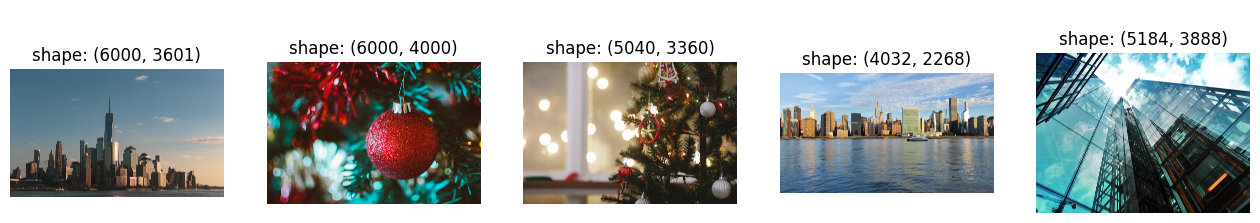

In [29]:
# Let's look at some of random images, five for now, we are working with. Nice to be one with the data.
t_utils.display_random_images(image_list, n=5)

### Run serially: each image transformation with a Python function

We will iterate through the images with batches of 10 (this can be changed) and process them. To simulate a computer-intensive operation 
on images, we are doing the following transformation and computations described above.

In [60]:
for idx in BATCHES:
    # Use the index to get N number of URLs to images
    image_batch_list = image_list[:idx]
    print(f"\nRunning {len(image_batch_list)} tasks serially....")
    
    # Run each one serially
    start = time.perf_counter()
    serial_results = run_serially(image_batch_list)
    end = time.perf_counter()
    elapsed = end - start
    
    # Keep track of batchs, execution times as a Tuple
    SERIAL_BATCH_TIMES.append((idx, round(elapsed, 2)))
    print(f"Serial transformations/computations of {len(image_batch_list)} images: {elapsed:.2f} sec")


Running 10 tasks serially....


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.62it/s]


Serial transformations/computations of 10 images: 6.19 sec

Running 20 tasks serially....


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.53it/s]


Serial transformations/computations of 20 images: 13.11 sec

Running 30 tasks serially....


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.49it/s]


Serial transformations/computations of 30 images: 20.18 sec

Running 40 tasks serially....


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:28<00:00,  1.38it/s]


Serial transformations/computations of 40 images: 28.99 sec

Running 50 tasks serially....


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:38<00:00,  1.31it/s]


Serial transformations/computations of 50 images: 38.07 sec

Running 60 tasks serially....


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:43<00:00,  1.36it/s]


Serial transformations/computations of 60 images: 43.96 sec

Running 70 tasks serially....


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:52<00:00,  1.34it/s]


Serial transformations/computations of 70 images: 52.07 sec

Running 80 tasks serially....


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [01:01<00:00,  1.30it/s]


Serial transformations/computations of 80 images: 61.78 sec

Running 90 tasks serially....


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [01:11<00:00,  1.25it/s]


Serial transformations/computations of 90 images: 71.81 sec

Running 100 tasks serially....


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.25it/s]

Serial transformations/computations of 100 images: 79.87 sec


### Run distributed: each image transformation with a Ray task

Let's create a Ray task for image within each batch and process them. Since 
our images are large, let's put them in the Ray Distributed object store. (We will cover this in the next tutorial, so bear with me for now).

In [61]:
# Put images in object store
object_refs_list = [ray.put(img) for img in image_list]
object_refs_list[:2], len(object_refs_list)

([ObjectRef(00ffffffffffffffffffffffffffffffffffffff010000002f010000),
  ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000030010000)],
 100)

In [62]:
# Iterate over batches of 10, launching Ray task for each image within the processing
# batch
for idx in BATCHES:
    image_obj_ref_batch_list = object_refs_list[:idx]
    print(f"\nRunning {len(image_obj_ref_batch_list)} tasks distributed....")
    
    # Run each one serially
    start = time.perf_counter()
    distributed_results = run_distributed(image_obj_ref_batch_list)
    end = time.perf_counter()
    elapsed = end - start
    
     # Keep track of batchs, execution times as a Tuple
    DISTRIBUTED_BATCH_TIMES.append((idx, round(elapsed, 2)))
    print(f"Distributed transformations/computations of {len(image_obj_ref_batch_list)} images: {elapsed:.2f} sec")


Running 10 tasks distributed....


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 6135.61it/s]


Distributed transformations/computations of 10 images: 2.14 sec

Running 20 tasks distributed....


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 9350.81it/s]


Distributed transformations/computations of 20 images: 4.08 sec

Running 30 tasks distributed....


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 8163.30it/s]


Distributed transformations/computations of 30 images: 5.52 sec

Running 40 tasks distributed....


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 12804.10it/s]


Distributed transformations/computations of 40 images: 9.58 sec

Running 50 tasks distributed....


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 19517.47it/s]


Distributed transformations/computations of 50 images: 10.54 sec

Running 60 tasks distributed....


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 10386.23it/s]


Distributed transformations/computations of 60 images: 11.82 sec

Running 70 tasks distributed....


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 17785.39it/s]


Distributed transformations/computations of 70 images: 13.91 sec

Running 80 tasks distributed....


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 17319.31it/s]


Distributed transformations/computations of 80 images: 16.37 sec

Running 90 tasks distributed....


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:00<00:00, 19003.59it/s]


Distributed transformations/computations of 90 images: 20.28 sec

Running 100 tasks distributed....


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 19124.13it/s]


Distributed transformations/computations of 100 images: 20.83 sec


### Compare and plot the serial vs. distributed computational times

In [63]:
# Print times for each and plot them for comparison
print(f"Serial times & batches     : {SERIAL_BATCH_TIMES}")
print(f"Distributed times & batches: {DISTRIBUTED_BATCH_TIMES}")

Serial times & batches     : [(10, 6.19), (20, 13.11), (30, 20.18), (40, 28.99), (50, 38.07), (60, 43.96), (70, 52.07), (80, 61.78), (90, 71.81), (100, 79.87)]
Distributed times & batches: [(10, 2.14), (20, 4.08), (30, 5.52), (40, 9.58), (50, 10.54), (60, 11.82), (70, 13.91), (80, 16.37), (90, 20.28), (100, 20.83)]


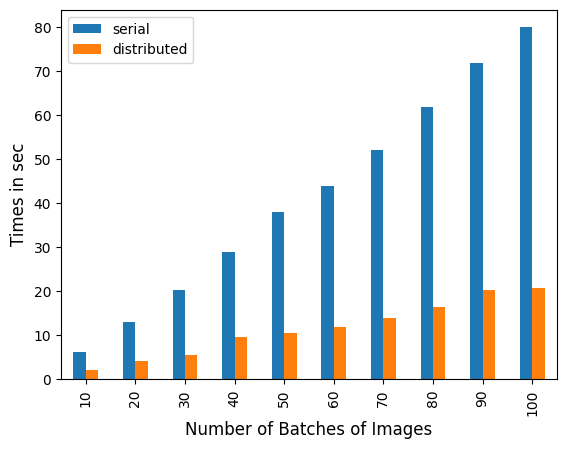

In [64]:
t_utils.plot_times(BATCHES, SERIAL_BATCH_TIMES, DISTRIBUTED_BATCH_TIMES)

### Recap

We can clearly observe that the overall execution times by Ray tasks is in order of **3-4x** faster than serial. Converting an existing serial compute-intensive
Python function is as simple as adding the `ray.remote()` operator to your Python function. And the rest Ray will take cover of all the hard bits: scheduling, execution, scaling, memory management, etc.

As you can see the benefits are tangible in execution times with Ray tasks.

### Exercise

1. Try using with four or five batches, each batch comprising of 20 and 25 image paths, and compare the execution times.
2. Is it faster, slower or the same?

### Example 4:  How to use Tasks for distributed batch inference 

Batch inference is a common distributed application workload in machine learning. It's a process of using a trained model to generate predictions for a collection of observations. 
Primarily, it has the following elements:

**Input dataset**: This is a large collection of observations to generate predictions for. The data is usually stored in an external storage system like S3, HDFS or database, across
many files.

**ML model**: This is a trained ML model that is usually also stored in an external storage system or in a model store.

**Predictions**: These are the outputs when applying the ML model on observations. Normally, predictions are usually written back to the storage system.

For purpose of this tutorial, we make the following provisions:
 * create a dummy model that returns some fake prediction
 * use real-world NYC taxi data to provide large data set for batch inference
 * return the predictions instead of writing it back to the disk

As an example of scaling pattern called **Different Data Same Function** (DDSF), also known as **Distributed Data Parallel** (DDP), our function in this diagram is the 
pretrained **model** and the data is split and disributed as **shards**.

|<img src="images/batch-inference.png" width="65%" height="35%">|
|:--|
|Distributed batch inference: Different Data Same Function (DDSF.|



Define a Python closure to load our pretrained model. This model is just a fake model that predicts whether a 
tip is warranted contigent on the number of fares (2 or more) on collective rides.

**Note**: This prediction is fake. The real model will invoke model's `model.predict(input_data)`. Yet
it suffices for this example.

In [45]:
def load_trained_model():
    # A fake model that predicts whether tips were given based on number of passengers in the taxi cab.
    def model(batch: pd.DataFrame) -> pd.DataFrame:
        
        # Some model payload so Ray copies the model in the shared plasma store to tasks scheduled across nodes.
        model.payload = np.arange(100, 100_000_000, dtype=float)
        model.cls = "regression"
        
        # give a tip if 2 or more passengers
        predict = batch["passenger_count"] >= 2 
        return pd.DataFrame({"score": predict})
    
    return model    

Let's define a Ray task that will handle each shard of the NYC taxt data

In [46]:
@ray.remote
def make_model_batch_predictions(model, shard_path, verbose=False):
    if verbose:
        print(f"Batch inference for shard file: {shard_path}")
    df = pq.read_table(shard_path).to_pandas()
    result = model(df)

    # Return our prediction data frame
    return result

Get the 12 files consisting of NYC data per month

In [47]:
# 12 files, one for each remote task.
input_files = [
    f"s3://anonymous@air-example-data/ursa-labs-taxi-data/downsampled_2009_full_year_data.parquet"
    f"/fe41422b01c04169af2a65a83b753e0f_{i:06d}.parquet" for i in range(12)
]

`ray.put()` the model just once to local object store, and then pass the reference to the remote tasks.
This is [Ray core API](https://docs.ray.io/en/latest/ray-core/package-ref.html) for putting objects into the Ray Plasma store. We discuss these APIs and Plasma store
in the next tutorial. 

In [48]:
# Get the model 
model = load_trained_model()

# Put the model object into the shared object store.
model_ref = ray.put(model)
model_ref

ObjectRef(00ffffffffffffffffffffffffffffffffffffff01000000ca000000)

In [49]:
# List for holding all object references from the model's predictions
result_refs = []

# Launch all prediction tasks. For each file create a Ray remote task
# to do a batch inference
for file in input_files:
    
    # Launch a prediction task by passing model reference and shard file to it.
    # NOTE: it would be highly inefficient if you are passing the model itself
    # like  make_model_prediction.remote(model, file), which in order to pass the model
    # to remote node will ray.put(model) for each task, potentially overwhelming
    # the local object store and causing out-of-memory or out-of-disk error.
    result_refs.append(make_model_batch_predictions.remote(model_ref, file))

Fetch the results

In [50]:
results = ray.get(result_refs)

In [51]:
 # Let's check predictions and output size.
for r in results:
    print(f"Predictions dataframe size: {len(r)} | Total score for tips: {r['score'].sum()}")

Predictions dataframe size: 141062 | Total score for tips: 46360
Predictions dataframe size: 133932 | Total score for tips: 42175
Predictions dataframe size: 144014 | Total score for tips: 45175
Predictions dataframe size: 143087 | Total score for tips: 45510
Predictions dataframe size: 148108 | Total score for tips: 47713
Predictions dataframe size: 141981 | Total score for tips: 45188
Predictions dataframe size: 136394 | Total score for tips: 43234
Predictions dataframe size: 136999 | Total score for tips: 45142
Predictions dataframe size: 139985 | Total score for tips: 44138
Predictions dataframe size: 156198 | Total score for tips: 49909
Predictions dataframe size: 142893 | Total score for tips: 46112
Predictions dataframe size: 145976 | Total score for tips: 48036


In [52]:
ray.shutdown()

### Exercises

1. Add a Python compute intensive function and convert it into a Ray task: pick some function from your repo.

### Homework
1. Read this blog,[Parallelizing Python Code](https://www.anyscale.com/blog/parallelizing-python-code), and try some examples.

### Next Step

Let's move on to the distributed [remote objects lesson](ex_02_remote_objs.ipynb).

### References

1. [Modern Parallel and Distributed Python: A Quick Tutorial on Ray](https://towardsdatascience.com/modern-parallel-and-distributed-python-a-quick-tutorial-on-ray-99f8d70369b8) by Robert Nishihara, co-creator of Ray and co-founder Anyscale
2. [Ray Core Introduction](https://www.anyscale.com/events/2022/02/03/introduction-to-ray-core-and-its-ecosystem) by Jules S. Damji

📖 [Back to Table of Contents](./ex_00_tutorial_overview.ipynb)<br>
➡ [Next notebook](./ex_02_remote_objs.ipynb) <br>